In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\caded\AppData\Local\Temp\ipykernel_16988\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent[0]
print("Most recent date:", most_recent_date)

Most recent date: 2017-08-23


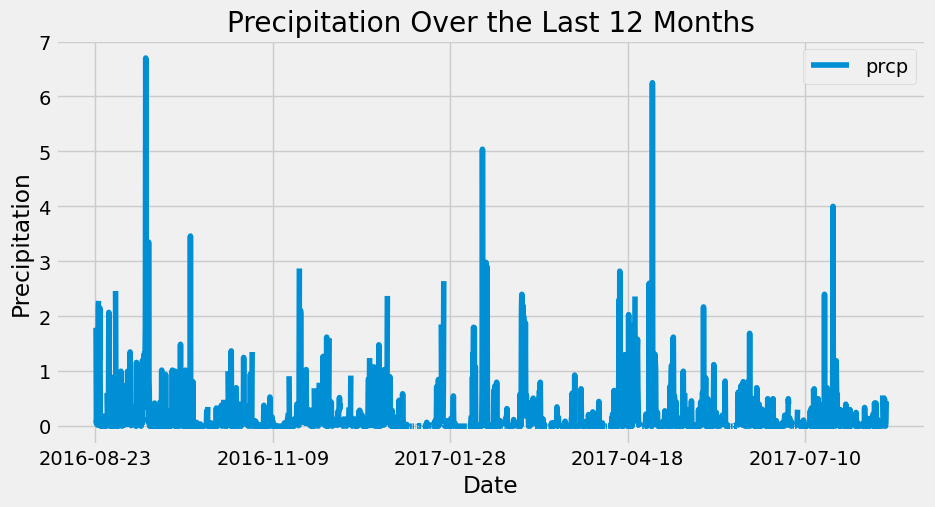

In [11]:
from datetime import datetime, timedelta

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_dt = datetime.strptime(most_recent_date, '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
year_ago_dt = most_recent_dt - timedelta(days=365)
year_ago_date = year_ago_dt.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(results, columns=['date', 'prcp'])

# Sort the dataframe by date
precip_df = precip_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(x='date', y='prcp', kind='line', figsize=(10, 5))
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Precipitation Over the Last 12 Months")
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
print(precip_df.describe())

              prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print("Total number of stations:", total_stations)

Total number of stations: 9


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

# Identify the most-active station (first result in the sorted list)
most_active_station = active_stations[0][0]

# List the stations and their counts in descending order.
for station, count in active_stations:
    print(f"Station: {station}, Observations: {count}")

Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stats = session.query(
    func.min(Measurement.tobs),
    func.avg(Measurement.tobs),
    func.max(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()
min_temp, avg_temp, max_temp = temp_stats[0]
print(f"Temperature stats for station {most_active_station}:\nMin: {min_temp}, Avg: {avg_temp:.1f}, Max: {max_temp}")

Temperature stats for station USC00519281:
Min: 54.0, Avg: 71.7, Max: 85.0


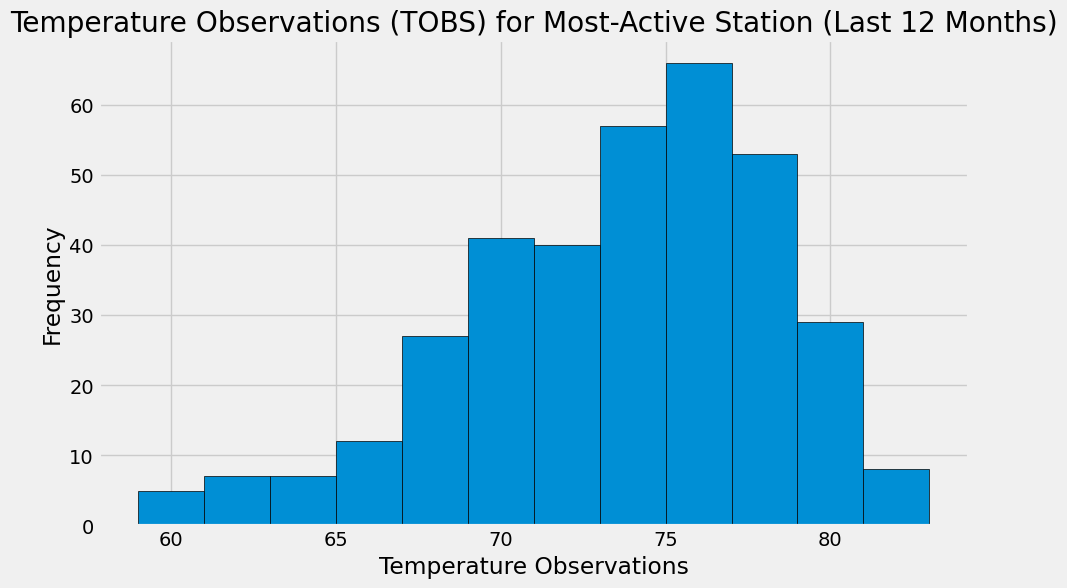

In [19]:
# Using the most active station id
most_recent_dt = datetime.strptime(most_recent_date, '%Y-%m-%d')
year_ago_dt = most_recent_dt - timedelta(days=365)
year_ago_date = year_ago_dt.strftime('%Y-%m-%d')
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_results = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station)\
    .filter(Measurement.date >= year_ago_date)\
    .all()
tobs_values = [result[0] for result in tobs_results]

plt.figure(figsize=(10, 6))
plt.hist(tobs_values, bins=12, edgecolor='black')
plt.xlabel("Temperature Observations")
plt.ylabel("Frequency")
plt.title("Temperature Observations (TOBS) for Most-Active Station (Last 12 Months)")
plt.show()

# Close Session

In [20]:
# Close Session
session.close()